In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  evaluation.core import State
from typing import Dict, List
import datetime
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from copy import deepcopy
import random
from Rushi.PPO.trainer import PPOTrainer
from Rushi.PPO.ml import PPOAgent
from Rushi.PPO.core import EarlyEnvironment, EarlyEnvs
from Rushi.PPO.utils import Logger, makeFeatures, getInvalidActionMask, getStateFeatures, getStockFeatures, interpolatorNotForDay,addPatterns
from evaluation.core import BaseStrategy
from evaluation.constants import HOLD_ACTION,BUY_ACTION,SELL_ACTION
from Rushi.PPO.constants import MAX_HOLDING, MAX_TRADE_TIME_IN_5_MINUTE, MAX_TRADE_TIME_IN_DAYS,ROLLING_WINDOW_SIZE_IN_DAYS, MAX_TRADE_TIME_IN_MINUTE, MODES, minutes_5_in_day, minutes_in_day, ROLLING_WINDOW_SIZE_IN_MINUTE, ROLLING_WINDOW_SIZE_IN_5_MINUTE,end_time_5_minute, end_time_minute
from Rushi.PPO.constants import end_time_minute, end_time_5_minute
from Rushi.PPO.ppoStrategy import PPOStrategy
from evaluation.backTest import BackTest
from tqdm import tqdm
from Rushi.PPO.rollingTrainer import RollingTrain

/home/captanlevi/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
#df = pd.read_csv("data/5minute/HDFCBANK.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")
addPatterns(df)

total values interpolated = 1230


In [3]:
train_days = ROLLING_WINDOW_SIZE_IN_DAYS + MAX_TRADE_TIME_IN_DAYS*30
test_days = MAX_TRADE_TIME_IN_DAYS
ppo_config = dict(
    num_envs = 128,
    num_steps = 256,
    observation_dim = 13,
    action_space_dim = 3,
    gamma = .9,
    num_mini_batches = 4,
    update_epochs = 4,
    clip_coef = .2,
    entropy_coef = .01,
    value_coef = .5,
    max_grad_norm = .5
)


# new config for patterns
"""
ppo_config = dict(
    num_envs = 128,
    num_steps = 256,
    observation_dim = 13 + 4,
    action_space_dim = 3,
    gamma = .9,
    num_mini_batches = 4,
    update_epochs = 4,
    clip_coef = .2,
    entropy_coef = .01,
    value_coef = .5,
    max_grad_norm = 1
)
"""
print(train_days, test_days)

100 3


In [4]:
class RollingTrain:
    def __init__(self,df,train_days, test_days, ppo_config,device,save_dir,mode,agent = None, updates = 1000):
        self.df = df
        self.train_days = train_days
        self.test_days = test_days
        self.ppo_config = ppo_config
        self.device = device
        self.save_dir = save_dir
        self.roll = 1
        if agent == None:
            self.agent = PPOAgent(lstm_hidden_size= 128,lstm_input_size= ppo_config["observation_dim"], layers= 2, output_dim= ppo_config["action_space_dim"])
        else:
            self.agent = agent
        
        self.agent.to(self.device)

        assert mode in MODES
        self.mode = mode
        unit = None
        if mode == "5minute":
            unit = minutes_5_in_day
        elif(mode == "minute"):
            unit = minutes_in_day
        else:
            unit = 1
        self.unit = unit

        self.train_indices = [0,self.train_days*unit -1]
        self.test_indices = [self.train_days*unit, self.train_days*unit + self.test_days*unit  - 1]
        self.updates = updates


        self.profit = 0
    def _rollIndices(self):
        self.roll += 1
        self.train_indices[0] += self.test_days*self.unit
        self.train_indices[1] += self.test_days*self.unit
        self.test_indices[0] += self.test_days*self.unit
        self.test_indices[1] += self.test_days*self.unit

    
    def getTrainEnvs(self, linspace = [1,1]):
        envs = []
        for _ in range(self.ppo_config["num_envs"]):
            envs.append(EarlyEnvironment(df = df.iloc[self.train_indices[0]:self.train_indices[1] + 1], mode= self.mode,linspace= linspace))
        early_envs = EarlyEnvs(early_environments= envs)
        return early_envs
    
    
    def evalRoll(self):
        ppo_strategy = PPOStrategy(df= df,mode= self.mode, agent= self.agent, device= self.device)
        back_test = BackTest(data= df, strategy= ppo_strategy, initial_cash= 100000, commision= .1, mode= "multi", short= False)
        limits = [self.test_indices[0],self.test_indices[1]]
        back_test.runStrategy(limits= limits)
        trades = sum(back_test.log["is_trade_complete"])
        print("num_trades =  {}".format(trades))
        return back_test.cash - back_test.initial_cash


    def save(self, logger : Logger = None):
        path = self.getAgentPath(roll= self.roll)
        self.agent.save(path= path)
        if logger == None:
            return
        logger_path = self.getLoggerPath(roll= self.roll)
        logger.save(path= logger_path)


    def getAgentPath(self,roll):
        return os.path.join(self.save_dir, "agent_roll_{}.pt".format(roll))
    def getLoggerPath(self,roll):
        return os.path.join(self.save_dir, "logger_roll_{}.pt".format(self.roll))

    
    def load(self,roll):
        path = self.getAgentPath(roll= roll)
        self.agent.load(path= path)
        logger_path = self.getLoggerPath(roll= roll)
        if os.path.exists(logger_path):
            return Logger.load(path= logger_path)
        return None

    def trainSingleRoll(self):
        logger = Logger(name= "STONK_ROLL_{}".format(self.roll))
        logger.default_step_size = 1000
        exists = False
        first_roll = self.roll == 1
        if os.path.exists(self.getAgentPath(roll= self.roll)):
            loaded_logger = self.load(roll= self.roll)
            if loaded_logger != None:
                logger = loaded_logger
            return None

        
 
        envs = self.getTrainEnvs(linspace= [1,1] if first_roll == True else [1,4])
        trainer = PPOTrainer(envs= envs, agent= self.agent, ppo_config= ppo_config, device= device, logger= logger)
        num_updates = self.updates if first_roll == True else 100
        print(num_updates)
        trainer.train(num_updates= num_updates, lr= 3e-4)
        return logger

    

    def getRolling(self):
        while self.test_indices[-1] < len(self.df):
            #self.load(roll= self.roll)
            logger = self.trainSingleRoll()
            self.profit += self.evalRoll()
            if logger != None:
                self.save(logger= logger)
            self._rollIndices()

            print("profit = {}".format(self.profit))
        


        
        



In [6]:
#agent = PPOAgent(lstm_hidden_size= 128,lstm_input_size= ppo_config["observation_dim"], layers= 2, output_dim= ppo_config["action_space_dim"])
#agent.load("Rushi/models_long_term_patterns/agent_roll_1.pt")


In [9]:
rolling_train = RollingTrain(df= df, train_days= train_days, test_days= test_days, ppo_config= ppo_config, device= device,
                             save_dir= "Rushi/HDFC_long_term_models", mode= "5minute", agent= None, updates= 4000
                            )

In [10]:
rolling_train.getRolling()

Ran from 2019-05-29 09:15:00 to 2019-05-31 15:25:00
Initial value = 100000
Final value = 100117.78535000005
num_trades =  23
profit = 117.78535000004922
Ran from 2019-06-03 09:15:00 to 2019-06-06 15:25:00
Initial value = 100000
Final value = 100013.71449999997
num_trades =  19
profit = 131.49985000002198
Ran from 2019-06-07 09:15:00 to 2019-06-11 15:25:00
Initial value = 100000
Final value = 99978.78700000001
num_trades =  30
profit = 110.28685000003316
Ran from 2019-06-12 09:15:00 to 2019-06-14 15:25:00
Initial value = 100000
Final value = 99897.20150000001
num_trades =  5
profit = 7.488350000043283
Ran from 2019-06-17 09:15:00 to 2019-06-19 15:25:00
Initial value = 100000
Final value = 99884.57199999997
num_trades =  15
profit = -107.9396499999857
Ran from 2019-06-20 09:15:00 to 2019-06-24 15:25:00
Initial value = 100000
Final value = 99879.16749999997
num_trades =  10
profit = -228.77215000001888
Ran from 2019-06-25 09:15:00 to 2019-06-27 15:25:00
Initial value = 100000
Final value 

KeyboardInterrupt: 

In [10]:
logger : Logger = Logger.load(path= "Rushi/models_long_term_trained/logger_roll_1.pt")
logger.getAllMetricNames()

['pg_loss',
 'value_loss',
 'entropy_loss',
 'avg_reward',
 'avg_length',
 'avg_profit',
 'avg_trades']

In [13]:
logger_patterns : Logger = Logger.load(path= "Rushi/models_long_term_patterns/logger_roll_1.pt")
logger.getAllMetricNames()

['pg_loss',
 'value_loss',
 'entropy_loss',
 'avg_reward',
 'avg_length',
 'avg_profit',
 'avg_trades']

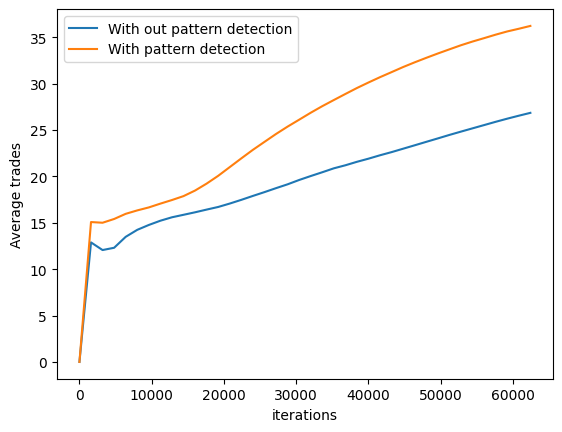

In [22]:
X = np.arange(len(logger.getMetric("avg_trades")))*1600

plt.plot(X,logger.getMetric("avg_trades"), label = "With out pattern detection")
plt.plot(X,logger_patterns.getMetric("avg_trades"), label = "With pattern detection")
plt.xlabel("iterations")
plt.ylabel("Average trades")
plt.legend()
plt.show()

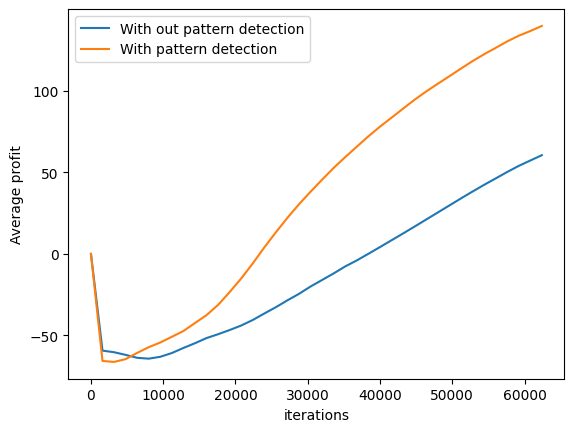

In [23]:
X = np.arange(len(logger.getMetric("avg_profit")))*1600
plt.plot(X,logger.getMetric("avg_profit"), label = "With out pattern detection")
plt.plot(X,logger_patterns.getMetric("avg_profit"), label = "With pattern detection")
plt.xlabel("iterations")
plt.ylabel("Average profit")
plt.legend()
plt.show()

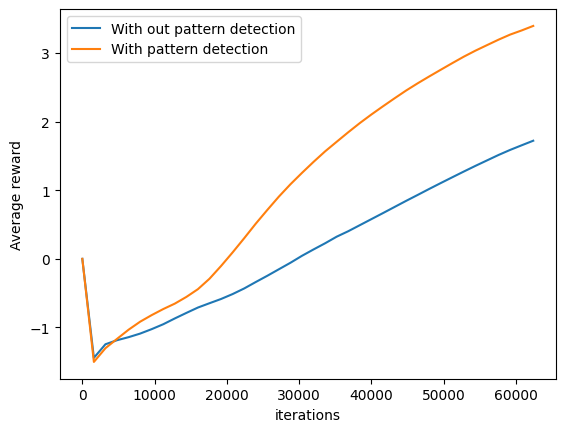

In [25]:
X = np.arange(len(logger.getMetric("avg_reward")))*1600
plt.plot(X,logger.getMetric("avg_reward"), label = "With out pattern detection")
plt.plot(X,logger_patterns.getMetric("avg_reward"), label = "With pattern detection")
plt.xlabel("iterations")
plt.ylabel("Average reward")
plt.legend()
plt.show()

In [1]:
envs = rolling_train.getTrainEnvs()

NameError: name 'rolling_train' is not defined

In [2]:
env = envs.early_environments[0]

NameError: name 'envs' is not defined

In [68]:
env.possible_indices

[0,
 75,
 150,
 225,
 300,
 375,
 450,
 525,
 600,
 675,
 750,
 825,
 900,
 975,
 1050,
 1125,
 1200,
 1275,
 1350]

In [69]:
env.reset()


{'next_obs': array([ 0.00444444,  0.00444444,  0.00444444,  0.00444444, -0.23209024,
         1.51242799, -0.1660417 , -0.04260383,  0.25327144,  0.51325301,
         0.0492322 , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ]),
 'invalid_action_mask': [False, False, True]}

In [70]:
env.step(action= HOLD_ACTION)

{'next_obs': array([ 0.00888889,  0.00888889,  0.00888889,  0.00888889, -0.04388625,
        -0.05846165, -0.30123005, -0.11356983,  0.25328075,  0.49975904,
         0.41419828, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ]),
 'done': 0,
 'reward': 0,
 'invalid_action_mask': [False, False, True]}

In [72]:
env.curr_iterator

{'index': 1126,
 'reward': 0,
 'length': 2,
 'prev_action': 0,
 'profit': 0,
 'trades': 0,
 'state': <evaluation.core.State at 0x75bbb0043550>,
 'prev_invalid_action_mask': [False, False, True]}

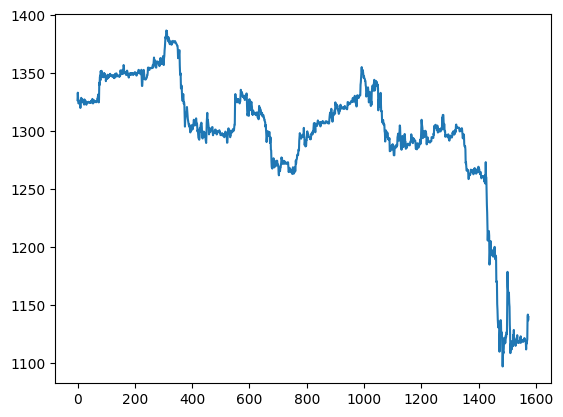

In [71]:
plt.plot(env.data["close"])

In [19]:
env = EarlyEnvironment(df= df.iloc[: ROLLING_WINDOW_SIZE_IN_5_MINUTE  + MAX_TRADE_TIME_IN_5_MINUTE], commision= .1, linspace= [1,1],mode= "5minute")
env.reset()
env.step(action= BUY_ACTION)
#env.step(action= HOLD_ACTION)

{'next_obs': array([ 0.00444444,  0.00444444,  0.00444444,  0.00444444,  2.83559746,
         3.10978014,  2.80067602,  2.79704491,  0.16813337,  0.92402235,
        -0.13463039,  0.2       ,  0.        ,  0.2       ,  0.        ,
         0.2       ,  0.        ]),
 'done': 0,
 'reward': 0,
 'invalid_action_mask': [False, False, True]}

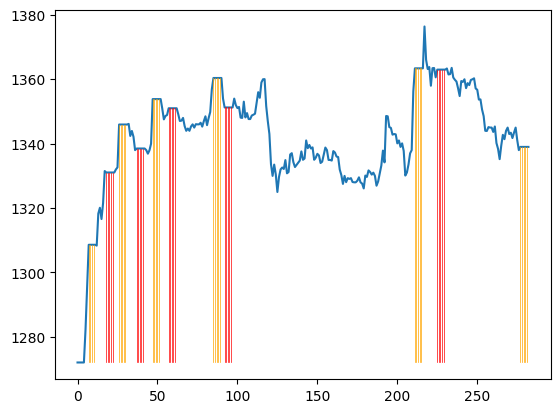

In [23]:
#plt.plot(back_test.log["action"])
X = range(len(back_test.log["closing_price"]))
y_mn = min(back_test.log["closing_price"])
plt.plot(X,back_test.log["closing_price"])

for i,action in enumerate(back_test.log["action"]):
    if action == BUY_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "red",linewidth = .5)
    elif action == SELL_ACTION:
        plt.plot([i,i],[y_mn,back_test.log["closing_price"][i]], c = "orange", linewidth = .5)

In [15]:
back_test.log["action"]

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [102]:
curr_agent.save("Rushi/models/agent_roll_1.pt")

In [10]:
trainer.storage["returns"].min()

KeyError: 'returns'

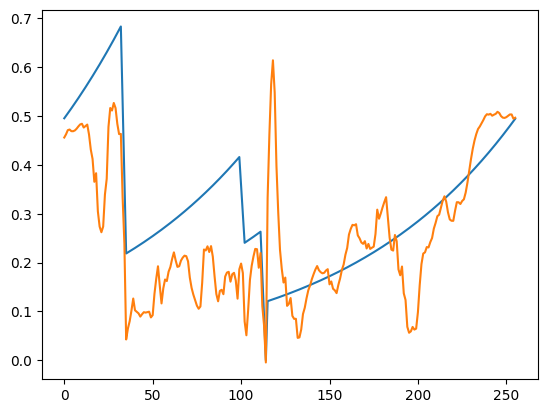

In [104]:
#plt.plot(trainer.storage["advantages"].cpu()[:,42])
plt.plot(trainer.storage["returns"].cpu()[:,42])
plt.plot(trainer.storage["values"].cpu()[:,42])
#plt.plot(trainer.storage["rewards"].cpu()[:,42])
#plt.plot(trainer.storage["dones"].cpu()[15,:])

In [ ]:
back_test.step_trade_counter

0

In [ ]:
back_test.log.keys()

dict_keys(['timestamp', 'money', 'is_trade_complete', 'stock_value', 'total_value', 'action', 'state_length', 'current_pointer', 'step_trade_counter'])

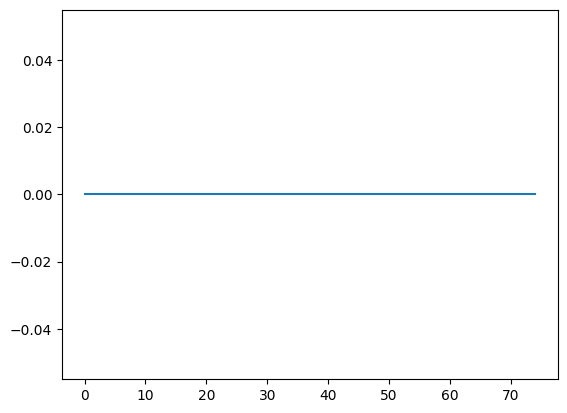

In [ ]:
plt.plot(back_test.log["action"][:100])

In [ ]:
len(back_test.log["action"])

1001

In [ ]:
agent.save(path= "Rushi/models/agent1.pt")

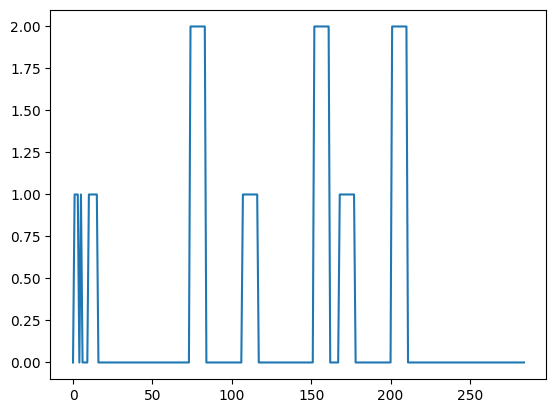

In [ ]:
plt.plot(back_test.log["action"])

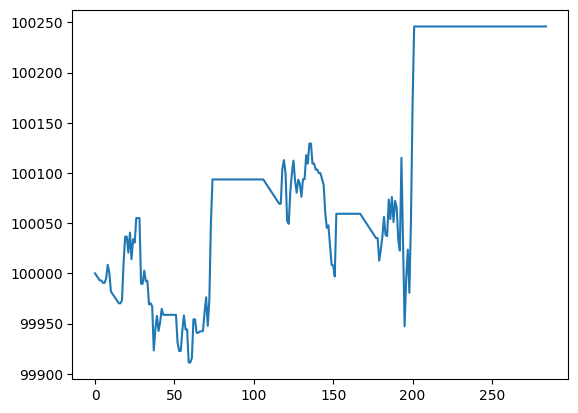

In [ ]:
back_test.plotValue()

In [ ]:
back_test.log["action"][-1]

1

In [ ]:
close = makeFeatures(df= df,mode= "5minute")["close"]
df_close = df.close.values

In [ ]:
len(close), len(df_close)

(3521, 5000)

In [ ]:
start_index = len(df_close) - len(close)

In [ ]:
df_close[start_index]

1272.5

In [ ]:
close[0]

1272.5